In [5]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path
from mne.decoding import Vectorizer, GeneralizingEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

### Read MEG data and metadata

In [2]:
ROOT = Path.cwd()                     # .../MEG/Data Analysis
MEG_ROOT = ROOT.parent                # .../MEG

LOCALIZER_EPO = (
    MEG_ROOT / "Data" / "Pilot" / "BIDS" / "derivatives" /
    "mne-bids-pipeline" / "sub-01" / "meg" / "sub-01_task-localizer_epo.fif"
)

epochs = mne.read_epochs(LOCALIZER_EPO)

# Read labels
df = pd.read_csv("metadata.csv")

print(df.head())

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
960 matching events found
No baseline correction applied
0 projection items activated
   subject_id       task  trial_block  trial_number stimulus_type meaning  \
0           1  localizer            1             1          word   carre   
1           1  localizer            1             2         image   croix   
2           1  localizer            1             3          word   dinde   
3           1  localizer            1             4         image   biche   
4           1  localizer            1             5          word  cercle   

  meaning_superordinate     stimulus participant_response  reaction_time  \
0                 shape   word_carre                  NaN            NaN

### Set X (data) and y (labels) for the model

In [61]:
words = df[df['stimulus_type'] == 'word']
images = df[df['stimulus_type'] == 'image']

labels = ['carre', 'losange', 'croix', 'cercle', 'biche', 'dinde', 'lampe', 'pince']

X = epochs["word"].pick_types(meg='mag').get_data(copy=False)
y = words["meaning"].values
y_pred = images["meaning"].values

d = {k:v for v, k in enumerate(labels)}

# Encode class labels to stable integer indices (ensures consistent column order across folds)
y_enc = np.array([d[s] for s in y])
y_pred_enc = np.array([d[s] for s in y_pred])

NUM_CLASSES = words["meaning"].nunique()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


### Define classifiers

In [ ]:
# Define pipeline: standardize features within folds, then linear classifier
clf = make_pipeline(
    StandardScaler(with_mean=True, with_std=True), 
    Vectorizer(),
    SVC(C=1, kernel='linear', decision_function_shape='ovo', probability = True) 
    )

time_gen = GeneralizingEstimator(clf, n_jobs=None, verbose=True)
time_gen.fit(X=X, y=y_enc)

In [74]:
# Define pipeline: standardize features within folds, then linear classifier
# clf = make_pipeline(
#     StandardScaler(),
#     LogisticRegression(solver="liblinear")
# )



100%|██████████| Fitting GeneralizingEstimator : 301/301 [02:52<00:00,    1.75it/s]


,base_estimator,Pipeline(step...ility=True))])
,scoring,None
,n_jobs,None
,position,0
,allow_2d,False
,verbose,True
,copy,True
,with_mean,True
,with_std,True
,C,1
,kernel,'linear'


In [75]:
scores = time_gen.score(
    X=epochs["image"].pick_types(meg='mag').get_data(copy=False), y=y_pred_enc
)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


100%|██████████| Scoring GeneralizingEstimator : 90601/90601 [09:13<00:00,  163.62it/s]


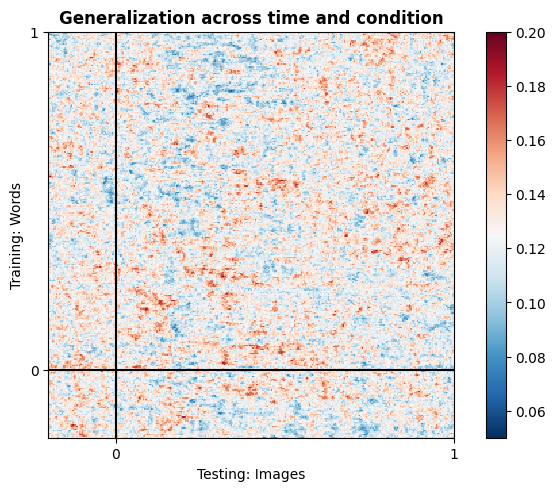

In [82]:
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(layout="constrained")
norm = TwoSlopeNorm(vmin=0.05, vcenter=1/8, vmax=0.2)
im = ax.matshow(
    scores,
    norm=norm,

    cmap="RdBu_r",
    origin="lower",
    extent=epochs.times[[0, -1, 0, -1]],
)

ax.axhline(0.0, color="k")
ax.axvline(0.0, color="k")
ax.xaxis.set_ticks_position("bottom")
ax.set_xlabel('Testing: Images')
ax.set_ylabel('Training: Words')
ax.set_title("Generalization across time and condition", fontweight="bold")
fig.colorbar(im, ax=ax)
plt.show()